# Real Estate Project Summary
## Imports

In [2]:
from sklearn.model_selection import cross_val_score
import statistics as stat
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import pandas as pd
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import sys
import os
repo_path = os.path.abspath('../')
sys.path.append(repo_path)
import scripts.addSA2 as addSA2

# show all attributes when displayed and don't truncate values
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

DIR_RAW = "../data/raw/"
DIR_CUR = "../data/curated/"
DIR_PLT = "../plots/"

## Data Download
Please **download all data** required before continuing.

In [ ]:
%run ../scripts/data_download.py

## Scraping

Rental data from [domain.com.au](https://www.domain.com.au) was scraped utilising the provided code as a basis. Additionally, we ensure all scraping compiled in with Domain's [robot.txt](https://www.domain.com.au/robots.txt)


This website has a huge number of listings, and by searching by **postcode** we collected a large number of metrics from each listed property.

We had to grab by postcode as when searching by VIC only 50 pages of properties would be listed.

This process was done in `scrape.ipynb`, and the results are saved in the raw data folder. <br />
The results from scraping are included in the data folder as the data is time sensitive.

In [4]:
df_scraped = pd.read_csv(f"{DIR_RAW}scraped_properties.csv")
print(f"There are {df_scraped.shape[0]} properties")
display(df_scraped.head(1))

There are 15271 properties


,url,price,address,num_beds,num_bath,num_car,property_type,agent,bond,internal_area,land_area,domain_says,neighbourhood_under_20,neighbourhood_20_to_39,neighbourhood_40_to_59,neighbourhood_above_60,neighbourhood_long_term_residents,neighbourhood_owners,neighbourhood_renter,neighbourhood_family,neighbourhood_single,performance_median_price,performance_auction_clearance,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_average_age,demographic_owner,demographic_renter,demographic_family,demographic_single,latitude,longitude
0,https://www.domain.com.au/40-esmond-street-ardeer-vic-3022-16035224,$400,40 Esmond Street Ardeer VIC 3022,3 Beds,2 Baths,1 Parking,House,Create Vic Real Estate,Bond $1738,NaN,NaN,"First listed on 11 August, this house has been on Domain for 22 days (last updated on 25 August). It was last sold in 2018 and \n 37 other 3 bedroom house in Ardeer have recently been sold.",26%,26%,26%,21%,66%,74%,26%,49%,51%,Median price: $680k,Auction clearance: 56%,Sold this year: 37,Avg days on market: 44,"Population: 3,099",Average age: 20 to 39,67%,33%,41%,59%,-37.775134,144.797067


## API Data

Now we get a bunch of distance data for various properties that we can merge into our other data

This is done with the `school_proximities.ipynb` notebook. But is quite an involved process, so that data is saved inside the git repository instead of being run here.

## Pre-Processing

Much of the data scraped required a lot of cleaning (via regex) to be useful. Such as, extracting the suburb from the address of a property. 

Many 'properties' were removed like car-spaces and even a NSW town that shares a postcode with a VIC town.

All the AIP data collected was then merged into each property.

Using statistical methods like box-plot and cook's distance addtional outliers were remove.

Finaly 2 datasets were created one holding all properties and the other an aggregate of property data around suburbs.

In [7]:
%run ../scripts/pre_processing.py
%run ../scripts/suburb_level_preprocessing.py

print("Property Data")
df_propeties = pd.read_csv(f"{DIR_CUR}pre_processed_data.csv")
print(f"There are {df_propeties.shape[0]} properties")
display(df_propeties.head(3))

print("\nSuburb Data")
df_suburb = pd.read_csv(f"{DIR_CUR}suburb_data.csv")
print(f"There are {df_suburb.shape[0]} suburbs")
display(df_suburb.head(3))

Property Data
There are 13308 properties


,url,postcode,suburb,state,weekly_rent,bond,num_beds,num_baths,num_parking,property_type,internal_area,land_area,last_sold,other_sold_n_bed_suburb,neighbourhood_under_20,neighbourhood_20_to_39,neighbourhood_40_to_59,neighbourhood_above_60,neighbourhood_long_term_residents,neighbourhood_owners,neighbourhood_renter,neighbourhood_family,neighbourhood_single,performance_median_price,performance_auction_clearance,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_owner,demographic_renter,demographic_family,demographic_single,demographic_average_age,latitude,longitude,school_duration,school_distance,park_duration,park_distance,shop_duration,shop_distance,train_duration,train_distance,stop_duration,stop_distance,SA2,population,median_weekly_income
0,https://www.domain.com.au/4-12-maylands-street-albion-vic-3020-16005364,3020,albion,vic,400.0,1738.0,2.0,2.0,1.0,Apartment / Unit / Flat,NaN,NaN,NaN,25.0,0.19,0.40,0.26,0.15,0.62,0.68,0.32,0.42,0.58,280000.0,NaN,25.0,104.0,4731.0,0.52,0.48,0.44,0.56,20 to 39,-37.776549,144.817980,1.238333,527.2,1.625000,717.5,2.571667,1577.0,2.106667,1215.7,0.71,532.1,213011328.0,7595,704
1,https://www.domain.com.au/5-44-adelaide-street-albion-vic-3020-16050746,3020,albion,vic,280.0,1218.0,2.0,1.0,1.0,Townhouse,NaN,NaN,2008.0,16.0,0.26,0.37,0.28,0.10,0.52,0.52,0.48,0.50,0.50,578000.0,0.3,16.0,NaN,4731.0,0.52,0.48,0.44,0.56,20 to 39,-37.780469,144.819923,0.528333,300.0,0.713333,301.2,2.756667,1371.8,2.225000,846.1,0.68,308.6,213011328.0,7595,704
2,https://www.domain.com.au/10-84-rockbank-rd-ardeer-vic-3022-15978682,3022,rockbank,vic,375.0,1630.0,2.0,1.0,1.0,House,NaN,NaN,2016.0,9.0,0.23,0.40,0.24,0.13,0.55,0.56,0.44,0.45,0.55,NaN,NaN,9.0,NaN,3099.0,0.67,0.33,0.41,0.59,20 to 39,-37.778214,144.798398,0.853333,355.9,0.623333,246.1,8.535000,5810.5,5.161667,2717.6,1.26,539.5,213011328.0,7595,704



Suburb Data
There are 211 suburbs


,suburb,count,weekly_rent,bond,num_beds,num_baths,num_parking,internal_area,land_area,other_sold_n_bed_suburb,neighbourhood_under_20,neighbourhood_20_to_39,neighbourhood_40_to_59,neighbourhood_above_60,neighbourhood_long_term_residents,neighbourhood_owners,neighbourhood_renter,neighbourhood_family,neighbourhood_single,performance_median_price,performance_auction_clearance,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_owner,demographic_renter,demographic_family,demographic_single,school_distance,park_distance,shop_distance,train_distance,stop_distance,population,median_weekly_income
0,abbotsford,52,548.600000,2387.020000,2.000000,1.365385,1.195122,NaN,NaN,79.120000,0.107692,0.555577,0.230577,0.104231,0.399231,0.347600,0.652400,0.505000,0.495000,762234.042553,0.514255,79.916667,72.510638,8443.680000,0.396000,0.604000,0.259200,0.740800,772.030769,434.905882,1081.582609,1406.405769,398.075000,9780.153846,1323.153846
1,abeckett street,19,501.842105,2470.909091,1.421053,1.105263,1.000000,NaN,NaN,455.736842,0.063158,0.776842,0.131579,0.033684,0.180714,0.260714,0.739286,0.285714,0.714286,443071.428571,0.436429,463.357143,127.357143,44828.428571,0.307143,0.692857,0.242143,0.757857,707.547368,493.621053,773.422222,388.752632,321.731579,17545.368421,675.105263
2,ada,25,455.416667,2034.720000,2.680000,1.800000,1.500000,NaN,NaN,135.750000,0.209565,0.466522,0.210870,0.107826,0.573000,0.550435,0.449565,0.528261,0.471739,727047.619048,0.534706,135.750000,71.761905,13646.280000,0.550000,0.450000,0.391200,0.608800,1815.372000,4185.372000,6630.104762,3456.820000,537.276000,12763.040000,781.040000


## Question 1
Using the grouped suburb data we try to predict suburb's rent based on features previously gathered

### Finding Most important features in predicting Rent
Using the F-score we find the 3 features of the suburb data to have the strongest predictive power to the median rent.

In [8]:
df_clean = df_suburb.drop(["suburb", "bond", "internal_area", "land_area"], axis=1)
df_clean = df_clean.dropna().reset_index(drop=True)

K_BEST = 3

X = df_clean.drop(["weekly_rent"], axis=1)
y = df_clean["weekly_rent"]

selector = SelectKBest(f_regression, k=K_BEST)
selector.fit_transform(X, y)
features_index = selector.get_support(indices=True)
predictors = list(X.iloc[:, features_index].columns)

print("The most important features are:")
for predictor in predictors:
    print(f"* {predictor}")

The most important features are:
* performance_median_price
* school_distance
* median_weekly_income


### Plots VS the weekly rent

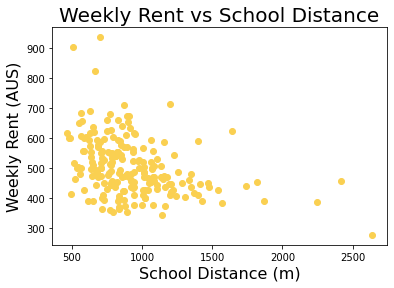

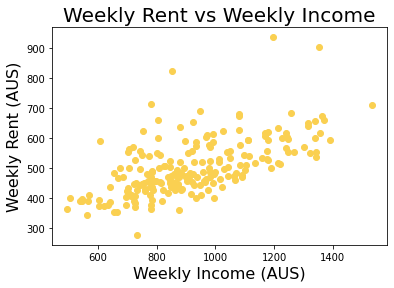

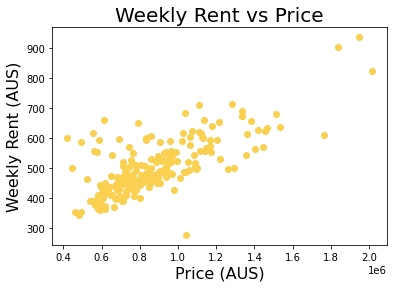

In [9]:
def vs(x, y, x_lab, y_lab, title, x_trans=lambda x: x, y_trans=lambda x: x):
    """creates a scatter plot between x and y"""
    plt.scatter(x_trans(x), y_trans(y), color="#fad051")
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=16)
    plt.ylabel(y_lab, size=16)
    plt.show()


vs(df_suburb["school_distance"], df_suburb["weekly_rent"], "School Distance (m)",
   "Weekly Rent (AUS)", "Weekly Rent vs School Distance")
vs(df_suburb["median_weekly_income"], df_suburb["weekly_rent"], "Weekly Income (AUS)",
   "Weekly Rent (AUS)", "Weekly Rent vs Weekly Income")
vs(df_suburb["performance_median_price"], df_suburb["weekly_rent"],
   "Price (AUS)", "Weekly Rent (AUS)", "Weekly Rent vs Price")

### Modeling using the 3 most important features
A Linear Regression and Multi-Layer Perceptron Regressor are fitted between rent and the 3 best features identified above 

In [11]:
response = "weekly_rent"
scoring = "r2"

FOLDS = 8


def test_model(model, X, y):
    """Applys an 8-cross fold validation finding the R^2 for each fold"""
    scores = cross_val_score(model, X, y, scoring=scoring, cv=FOLDS)
    print(f"Min R^2:    {min(scores):.3f}")
    print(f"Max R^2:    {max(scores):.3f}")
    print(f"Median R^2: {stat.median(scores):.3f}")
    print(f"Mean R^2:   {stat.mean(scores):.3f}")


df_na_out = df_suburb.dropna(subset=predictors)

df_na_out = df_suburb.dropna(subset=predictors + [response]).reset_index(drop=True)

trans = ColumnTransformer(
    transformers=[("scale", StandardScaler(), predictors)])
X = trans.fit_transform(df_na_out[predictors])
y = df_na_out["weekly_rent"]

print("Linear Regression:")
test_model(LinearRegression(), X, y)

print("\nMulti-Layer Perceptron Regressor:")
test_model(MLPRegressor(random_state=30027,
           max_iter=1000000, n_iter_no_change=15), X, y)

Linear Regression:
Min R^2:    0.273
Max R^2:    0.782
Median R^2: 0.720
Mean R^2:   0.632

Multi-Layer Perceptron Regressor:
Min R^2:    0.202
Max R^2:    0.900
Median R^2: 0.678
Mean R^2:   0.585


Looking at the median this has resulted in 2 reasonable models in predicting rent price. Meaning our 3 important features are good indicators of rent.

## Question 2

For this question we need historical data instead of current, data. This has been scraped from domain.com.au, and is pre-processed seperately. (See predict_future_preprocess.ipynb for details)

(run this script if predict_future_preprocessing.ipynb notebook not run)

In [ ]:
%run ../scripts/predict_future_preprocessing.py

We originally tried fitting a linear regression model, but this gave poor performance, so we used an approach using predictor metrics instead.

## Predictor Metrics:

* Historical 3-year-growth: While a regression to the mean is fairly likely in many cases, a suburb having a high growth rate in previous years should still indicate that that is more likely to continue.

* Current growth rate: Extrapolating the 2022 growth rate to a 3 year prediction is unlikely to be accurate, but it is once again a decent indicator.

* New dwellings / population: If there is a high number of new dwellings relative to the population, then in theory the increased supply will lead to decreased house value.

* non residential value: The theory behind using this metric, is that non-residential housing indicates an increase in local business. This should in theory increase the value of the area. This may be incorrect, as it might indicate a non-residential area, but not sure.

* Clearance: A high clearance rate should indicate a high demand in the area, so in theory an increase in future prices.

* Average days on market: A low number of days on the market, should indicate (like clearance), a high demand for houses in the area.

* sold / population: If there are a high number of sales relative to the population it indicates market interest.

* Unfortunately due to a lack of historical data for many areas, and many of these metrics, we will have to decide aribtrarily on the importance of each feature. I will then create a ranking of each feature and use this as the input for the algorithm.

https://propertyupdate.com.au/property-investment-melbourne/#is-it-the-right-time-to-get-into-the-melbourne-property-market

https://www.trilogyfunding.com.au/blog/7-key-market-indicators-every-property-investor-should-understand-april-2015/


https://www.mmj.com.au/resources/blog/5-key-market-indicators-every-property-investor-should-know/

In [ ]:
df = pd.read_csv(f"../data/curated/future_prediction_data.csv")

# Get rankings for each feature
predict_df = pd.DataFrame()
predict_df["suburb"] = df["suburb"]
predict_df["avg_days_on_market"] = df["avg_days_on_market"].rank(
    ascending=False)  # low is better
predict_df["3_year_growth"] = df["3_year_growth"].rank(
    ascending=True)  # high is better
predict_df["2022_growth"] = df["2022_growth"].rank(
    ascending=True)  # high is better
predict_df["sold/pop"] = (df["2022_n_sold"]/df["suburb_population"]
                          ).rank(ascending=True).fillna(0)  # high is better
predict_df["dwellings/pop"] = (df["new_dwellings_2021"]/df["suburb_population"]
                               ).rank(ascending=False).fillna(0)  # low is better
predict_df["non_residential_value"] = df["non_residential_value_2021"].rank(
    ascending=True)  # higher is better
predict_df["clearance"] = df["clearance"].rank(
    ascending=True)  # higher is better
predict_df["sum"] = predict_df.sum(axis=1)
predict_df["SA2"] = df["SA2"]


In [ ]:
predict_df = predict_df.sort_values(by="sum", ascending=False)
predict_df.to_csv(f"../data/curated/prediction_results.csv")

In [ ]:
display(predict_df)

We can then see the ranking of suburbs. Flinders, Blairgowrie, tootgarook, mccrae, and mornington take the top spots.

Our business recomendations will then be to invest in properties along the mornington peninsula, as these tend to have the highest predicted growth rate.

## Question 3

We start off by reading the data. We'll be using the processed dataset with *ptv*, *parks*, *schools*, and *shopping centres* proximity addded. Note that we'll be using the average proximity here

In [ ]:
import pandas as pd
from pyrosm import OSM, get_data
import ssl
from scipy.stats import percentileofscore
import numpy as np
import geopandas as gpd
import folium
import sys
sys.path.append("../scripts")
from liveability_helper import median_rent, score

property_df = pd.read_csv(
    "/Users/matthewrush/Documents/generic-real-estate-consulting-project-group-32/data/curated/pre_processed_data.csv",
    usecols=[
        "url",
        "postcode",
        "school_duration",
        "school_distance",
        "park_duration",
        "park_distance",
        "shop_duration",
        "shop_distance",
    ],
)

postcode_df = pd.read_csv(
    "../data/raw/postcode.csv",
    usecols=["postcode", "locality"],
)

api_df = pd.read_csv(
    "../data/curated/api_data.csv",
    usecols=[
        "url",
        "train_duration",
        "train_distance",
        "stop_duration",
        "stop_distance",
    ],
)

historical_df = pd.read_csv(
    "../data/curated/historical_sales.csv",
    usecols=["postcode", "n_sold", "median_rent"],
)

property_df = pd.merge(property_df, api_df)
property_df = property_df.groupby("postcode").mean().reset_index()


Now we find the median rent of each suburb using the scraped data

In [ ]:
property_df["median_rent"] = property_df.apply(
    lambda x: median_rent(historical_df, x["postcode"]), axis=1
)
property_df = property_df.where(pd.notnull(property_df["median_rent"]), 0)

property_df = property_df[property_df["median_rent"] != 0]


Now we find the liveability scores of each suburb.

The score is calculated by retrieving the percentile value of each factors of each suburb relative to other suburbs. 

This means the lower the score, the better. We're giving each factors equal weights here since we don't have evidence that suggest we should weight it otherwise

The code is hidden since it is quite long and doesn't do anything too complicated. If interested, please view 

```
/scripts/liveability_helper.py
```

In [ ]:
property_df["score"] = property_df.apply(
    lambda x: score(
        property_df,
        x["school_duration"],
        x["school_distance"],
        x["park_duration"],
        x["park_distance"],
        x["shop_duration"],
        x["shop_distance"],
        x["train_duration"],
        x["train_distance"],
        x["stop_duration"],
        x["stop_distance"],
        x["median_rent"],
    ),
    axis=1,
)

property_df = property_df.sort_values("score")
# property_df.to_csv("../data/curated/q3_live.csv")


And here we are, the top 5 most liveable suburbs:


In [ ]:
property_df[["postcode", "median_rent"]].head()


Let's do some visualisation now. We can see that the top 5 suburbs fall mostly in inner sububs with good PTV, schools and park areas.

In [ ]:
shape = gpd.read_file(
    "../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.shp")
shape = shape.loc[shape.STE_NAME21 == "Victoria"]
shape = shape.loc[shape.geometry != None]
shape["SA2_CODE21"] = pd.to_numeric(shape["SA2_CODE21"], errors="ignore")

map_data = pd.DataFrame(shape["SA2_NAME21"])
map_data["liveable"] = 0

map_data.loc[
    map_data["SA2_NAME21"].isin(
        [
            "Brunswick - South",
            "West Melbourne - Residential",
            "South Yarra - North",
            "Northcote",
            "Armadale",
        ]
    ),
    "liveable",
] = 1


gdf = gpd.GeoDataFrame(
    shape
)

geoJSON = gdf[['SA2_NAME21', 'geometry']].set_index('SA2_NAME21').to_json()
# geoJSON = gdf[['LocationID', 'geometry', 'zone_x']].drop_duplicates(
#     'LocationID').set_index('zone_x').to_json()

_map = folium.Map(location=[-37.840935, 144.946457],
                  tiles="cartodbpositron", zoom_start=11)
# refer to the folium documentations on how to plot aggregated data.
_map.add_child(folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=map_data,
    columns=["SA2_NAME21", "liveable"],
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=.1,
    fill_color='Blues',))
_map


To find the most liveable **AND** affordable suburbs, we have to add in a penalising factor in mediant rent. We also add a constant multiplier in the penalising factor as well. This factor is tuned such that a (what we deem) sufficient amount of top suburbs fall around Melbourne median rent.

Note that the multiplier should deduct a more expensive suburb's score more than a cheaper suburb's score.

Also note that the median rent we're working with is:

In [ ]:
property_df.median_rent.median()


In [ ]:
property_df["affordability_score"] = property_df.apply(
    lambda x: score(
        property_df,
        x["school_duration"],
        x["school_distance"],
        x["park_duration"],
        x["park_distance"],
        x["shop_duration"],
        x["shop_distance"],
        x["train_duration"],
        x["train_distance"],
        x["stop_duration"],
        x["stop_distance"],
        x["median_rent"],
        affordable=True,
    ),
    axis=1,
)

property_df = property_df.sort_values("affordability_score")
property_df[["postcode", "median_rent"]].head()
# property_df.to_csv("../data/curated/q3_live_afford.csv")


The top 5 median rent is noticably lower across the top 5, besides **West Melbourne** which tops the list. The suburb just does so well with all of our criterias.

Let's do some visualisation again

In [ ]:
map_data = pd.DataFrame(shape["SA2_NAME21"])
map_data["liveable"] = 0
map_data.loc[
    map_data["SA2_NAME21"].isin(
        [
            "Melbourne CBD - West",
            "Melbourne CBD - East",
            "West Melbourne - Residential",
            "Noble Park - East",
            "Footscray",
            "St Albans - South",
        ]
    ),
    "liveable",
] = 1

_map = folium.Map(location=[-37.840935, 144.946457],
                  tiles="cartodbpositron", zoom_start=11)
# refer to the folium documentations on how to plot aggregated data.
_map.add_child(folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=map_data,
    columns=["SA2_NAME21", "liveable"],
    key_on="feature.id",
    fill_opacity=0.7,
    line_opacity=.1,
    fill_color='Blues',))
_map


Noticably some pressure outwards to the outer suburbs. This is the penalising factor in play here.

This is a good starting point. We recommend adding more factors - for example crime rates, amenities/nightlife, and potentially traffic data to improve this ranking system. 

The proximity scores are also based on available properties for rent on domain. To get a better picture of a suburb's profile - consider calculating proximity potentually on a grid-based pattern. This may allow you to get a better understanding of the suburb without having to calculate proximity for every single property (though that is also an option)
